In [1]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal, ndimage
import tifffile
import os

/home/bq_llettermann/.conda/envs/JAX22GPU/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
DATA_REPO = '/bwSDS/sd23l003/llettermann/ChiralityPaperData/DataRepository/'  # Should point to data repo from https://doi.org/10.11588/DATA/4YBYXE

In [3]:
def comp_threshed(data, th=50):
    threshed = data > th
    threshed = ndimage.binary_fill_holes(threshed)
    threshed = ndimage.binary_dilation(threshed, iterations=1)
    labels, nlabels = ndimage.label(threshed)
    maxlabel = np.argmax(np.bincount(labels.flat)[1:])+1
    threshed = labels == maxlabel
    threshed = ndimage.binary_erosion(threshed, iterations=1)
    coords = 1.*np.stack(np.where(threshed), axis=1)
    center = np.mean(coords, axis=0)
    return threshed, coords, center

In [4]:
path = os.path.join(DATA_REPO, 'STED_Data', 'Example_Sporozoite.tif')
#               x0,      y0,      r,      phi0,  phi1
circ_params = [11.19,	79.07,	68.53,	-1.00,	-1.73]

In [5]:
to_take = 2
data = tifffile.imread(path)
x0, y0, r, phi0, phi1 = circ_params

threshed, coords, center = comp_threshed(data, th=50)
mean_z_pos = np.mean(center[0])

nphis = int(np.round((np.abs(phi1-phi0)%(2*np.pi)*r)/.3))
dphi=0.05
if phi0<phi1:
    phis = np.linspace(phi0-dphi, phi1+dphi, nphis)
else:
    phis = np.linspace(phi1-dphi, phi0+dphi, nphis)[::-1]

x = x0 + r * np.cos(phis)
y = y0 + r * np.sin(phis)
z = 15*np.ones_like(x)
shorter_axis = np.array(data.shape[1:]).argmin()+1

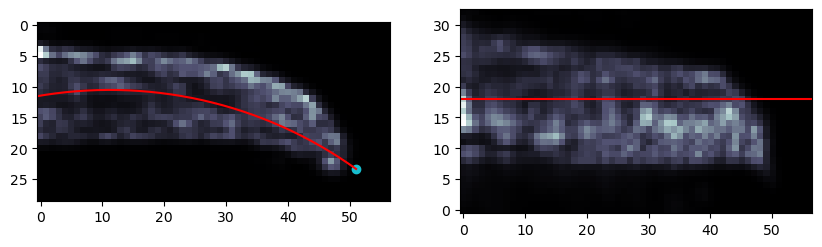

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
z = 15*np.ones_like(x)
ax[0].plot(x, y, 'r')
ax[0].scatter(x[0], y[0], c='C9')
ax[0].imshow(data.max(axis=0), cmap='bone')
ax[1].imshow(data.max(axis=shorter_axis), origin='lower', cmap='bone')
ax[1].axhline(mean_z_pos, color='r')

/tmp/ipykernel_162413/2772608781.py:25: RuntimeWarning: Mean of empty slice
  im2 = ax[axi].imshow(np.nanmean(sections[np.maximum(i-2,0):i+3]*


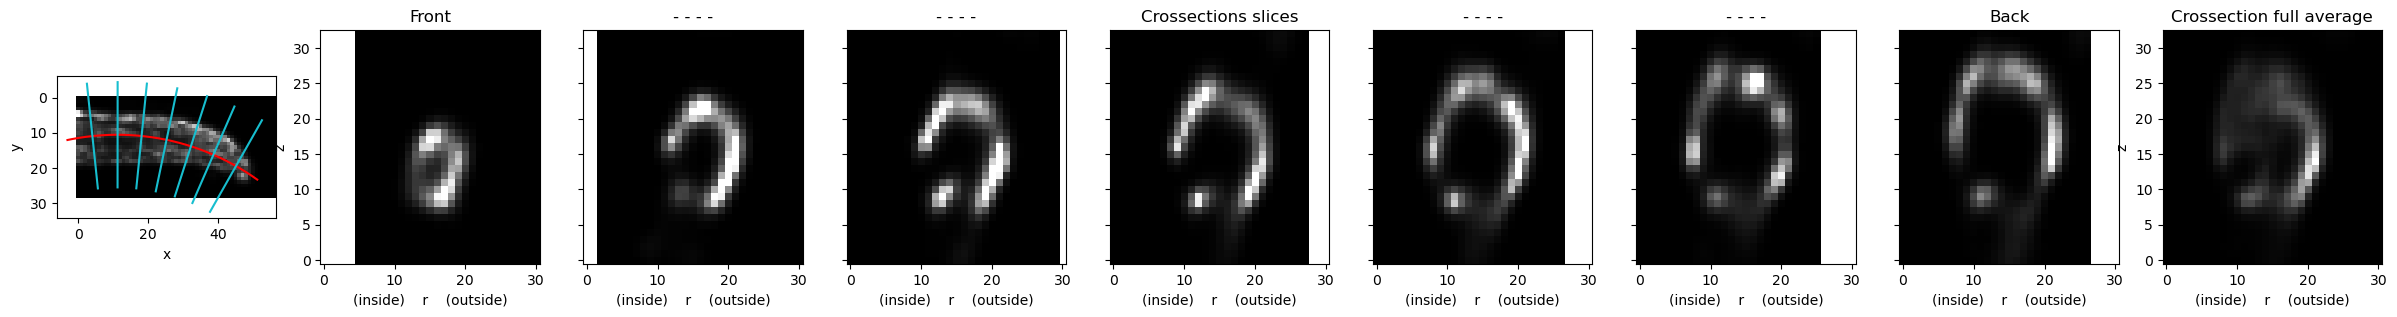

In [7]:
cs_size = 15
sections, xs_s, ys_s = [], [], []
for i_s in range(len(phis)):
    xy_s = np.array([x[i_s], y[i_s]])
    n_s = np.array([np.cos(phis[i_s]), np.sin(phis[i_s])])
    xs = xy_s[0] + np.linspace(-cs_size,cs_size,2*cs_size+1) * n_s[0]
    ys = xy_s[1] + np.linspace(-cs_size,cs_size,2*cs_size+1) * n_s[1]

    #ax[0].plot(xs, ys, 'g')
    section = np.array([ndimage.map_coordinates(d.astype(float), np.stack((ys,xs), axis=0), order=2, cval=np.nan, mode='constant') for d in data])
    sections.append(section)
    xs_s.append(xs)
    ys_s.append(ys)
sections = np.array(sections)

n_secs = 7
fig, ax = plt.subplots(1,n_secs+2, figsize=(30,5))
ax[0].imshow(data.max(axis=0), cmap='gray')
ax[0].plot(x, y, 'r')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
for i, axi in zip(np.round(np.linspace(0, len(phis)-1, n_secs+2)[1:-1]).astype(int), np.arange(1,n_secs+1)):
    l1 = ax[0].plot(xs_s[i], ys_s[i], 'C9')

    im2 = ax[axi].imshow(np.nanmean(sections[np.maximum(i-2,0):i+3]*
                                np.array([1.,2,3,2,1])[(i<2)*(2-i):None if (i<(len(phis)-2)) else (4-(i-len(phis)+2))][:,None,None], axis=0), 
                                cmap='gray', origin='lower', vmin=0, vmax=300)#, norm=norm)
    ax[axi].set_xlabel('(inside)    r    (outside)')
    if axi==1:
        ax[axi].set_ylabel('z')
    else:
        ax[axi].set_yticklabels([])
    if axi==1:
        ax[axi].set_title('Front')
    elif axi==n_secs:
        ax[axi].set_title('Back')
    elif axi==n_secs//2+1:
        ax[axi].set_title('Crossections slices')
    else:
        ax[axi].set_title('- - - -')


ax[-1].imshow(np.nanmean(sections, axis=0), cmap='gray', origin='lower')
ax[-1].set_xlabel('(inside)    r    (outside)')
ax[-1].set_ylabel('z')
ax[-1].set_title('Crossection full average')

resdict = {'x': x, 'y': y, 'z': z, 'sections': sections, 'xs_s': xs_s, 'ys_s': ys_s, 'phis': phis, 
               'shorter_axis': shorter_axis, 'mean_z_pos': mean_z_pos, 'to_take': to_take, 'topview': data.max(axis=0)}

In [8]:
cmap = cm.get_cmap('gray', 256)
cmap.set_bad('black')

def plot_STED_res_ax(to_take, ax, task, i_cs = None, rotate=False, linecol='red', cs_sigma=None): # Taks: topview, crossection, average
    if task == 'topview':
        x, y = resdict['x'], resdict['y']
        if rotate:
            ax.imshow(np.pad(resdict['topview'].T,((10,10),(10,10))), cmap=cmap)
            ax.plot(y+10, x+10, c=linecol)
            ax.invert_xaxis()
        else:
            ax.imshow(np.pad(resdict['topview'], ((10,10),(10,10))), cmap=cmap)
            ax.plot(x+10, y+10, c=linecol)
    elif task == 'crossection':
        ax.imshow(np.pad(ndimage.gaussian_filter(np.nan_to_num(resdict['sections']), (cs_sigma,0,0), truncate=1)[i_cs],((4,4),(4,4))), cmap=cmap, origin='lower')
    elif task == 'average':
        ax.imshow(np.nanmean(resdict['sections'], axis=0), cmap=cmap, origin='lower')

#@partial(jax.jit, static_argnums=(2,3))
def radial_average_of_image(im, center, sum_r=False, max_r=20):
    y, x = np.indices(im.shape)
    r = jnp.sqrt((x-center[1])**2 + (y-center[0])**2)
    r = r.astype(int)
    tbin = jnp.bincount(r.ravel(), jnp.nan_to_num(im).ravel()-jnp.nanmin(im), length=max_r)
    nr = jnp.bincount(r.ravel(), length=max_r)
    if not sum_r:
        radialprofile = tbin/nr
    else:
        radialprofile = tbin
        # radialprofile = radialprofile*2*np.pi*np.arange(len(radialprofile))
    return radialprofile

def angular_profile_of_image(im, center, max_r=np.inf,n_bins=30):
    y, x = np.indices(im.shape)
    r = jnp.sqrt((x-center[1])**2 + (y-center[0])**2)
    t = jnp.arctan2(y-center[0], x-center[1])
    binnum = jnp.floor(((t+np.pi/2)%(2*np.pi))/np.pi/2*n_bins).astype(int)
    #tbin = np.bincount(binnum.ravel(), (im*(r<max_r)).ravel())
    #nt = np.bincount(binnum.ravel())
    #angularprofile = tbin/nt
    angularprofile = jnp.array([(jnp.max(jnp.where((r<max_r)*(binnum==i), jnp.nan_to_num(im), 0))) for i in range(n_bins)])
    return angularprofile

def lossfunc(cs_here, center, i, j):
    return jnp.sum(radial_average_of_image(cs_here, center+jnp.array([j, i]), sum_r=True)**2)*jnp.sum(angular_profile_of_image(cs_here, center+jnp.array([j, i]))**0.5)

lossfunc_v = jax.jit(jax.vmap(jax.vmap(lossfunc, in_axes=(None,None,0,None)), in_axes=(None,None,None,0)))

29.02723744701454


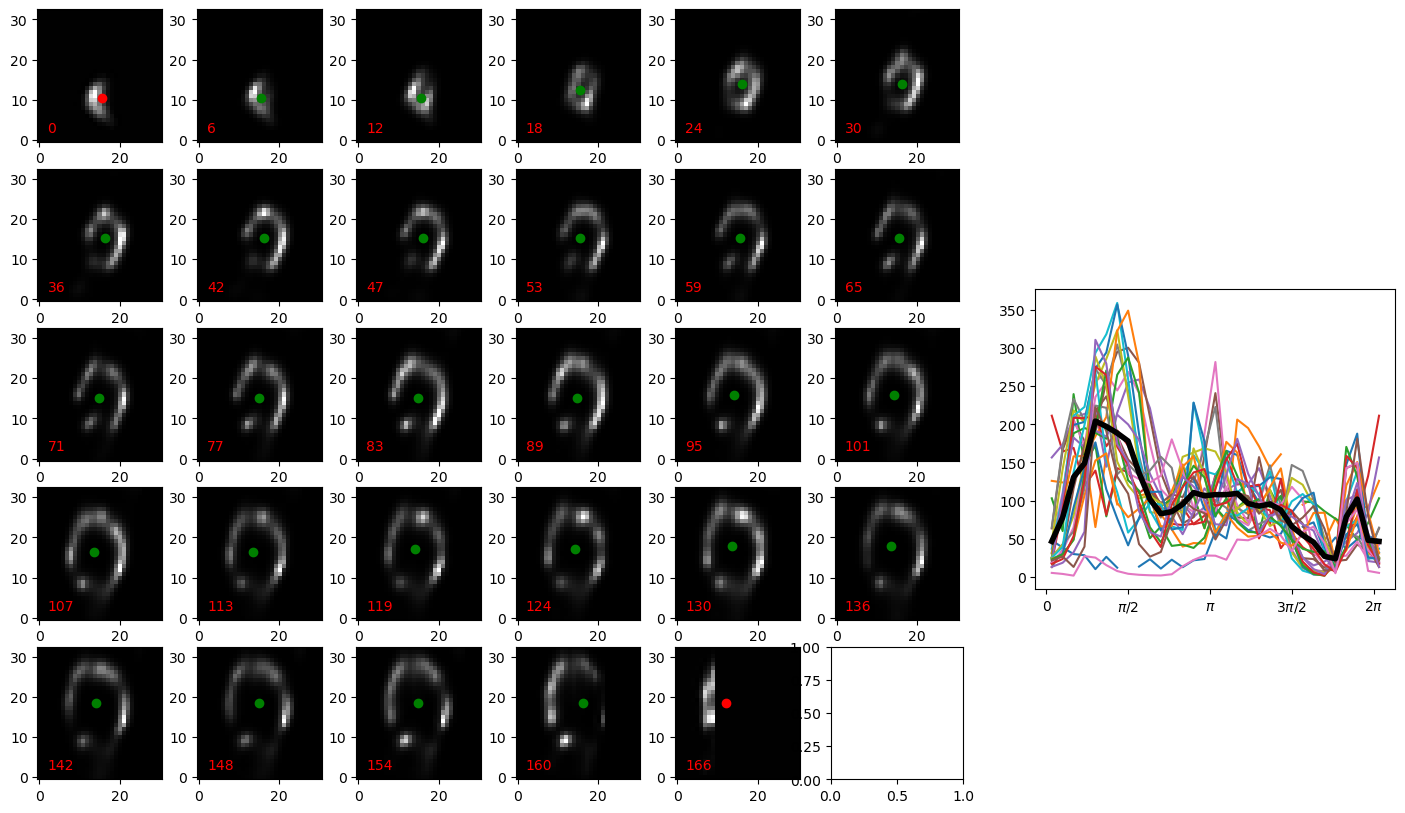

In [9]:
rd = resdict
slice_offcet = np.mean(np.diff(rd['phis']))*r
slices_tt = np.linspace(0, len(rd['phis'])-1, int(np.round(len(rd['phis'])/2*np.abs(slice_offcet))))
slices_tt = np.round(slices_tt).astype(int)
slice_thickness = np.mean(np.diff(slices_tt))

n_cols = np.ceil(np.sqrt(len(slices_tt))).astype(int)
n_rows = np.ceil(len(slices_tt)/n_cols).astype(int)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
cs_smoothed =  ndimage.gaussian_filter(np.nan_to_num(rd['sections']), (slice_thickness,0,0), truncate=1)
center_th = np.nanquantile(cs_smoothed, 0.9)
print(center_th)
ang_profs = []
ang_profs_valid = []
for j, j_cs in enumerate(slices_tt):
    valid = True
    cs_here = cs_smoothed[j_cs]
    center_co = 5
    #center = np.array(ndimage.center_of_mass(cs_here[center_co:-center_co, center_co:-center_co]>center_th))+center_co
    #if np.isnan(center).any():
    center = np.array(cs_here.shape)/2
    center_change = np.linspace(-8,8,25)
    #rad_prof_sums = np.array([[np.sum(radial_average_of_image(cs_here, center+np.array([j, i]), sum_r=True)**2)*np.sum(angular_profile_of_image(cs_here, center+np.array([j, i]))**0.5)
    #                           for i in center_change] for j in center_change])
    rad_prof_sums = lossfunc_v(cs_here, center, center_change, center_change)
    center = center + center_change[list(np.unravel_index(np.argmax(rad_prof_sums), rad_prof_sums.shape))]
    rad = np.argmax(radial_average_of_image(cs_here, center, sum_r=True))
    ang_prof = np.array(angular_profile_of_image(cs_here, center, max_r=1.5*rad, n_bins=30))
    ang_prof[ang_prof==0] = np.nan
    ang_profs.append(ang_prof)

    if (np.isnan(cs_here).sum()+(cs_here==0).sum()>1000 or
        (cs_here[center_co:-center_co, center_co:-center_co]>center_th).sum()<5):
        valid = False
    if (ang_prof<0.5*ang_prof.mean()).sum()>0.5*ang_prof.size:
        valid = False
        
    ang_profs_valid.append(valid)  
    ax.flatten()[j].imshow(cs_here, cmap=cmap, origin='lower')
    ax.flatten()[j].text(2,2, f'{j_cs}', color='red')
    ax.flatten()[j].scatter(center[1], center[0], c='green' if valid else 'red')
    #ax.flatten()[i].axis('off')
ang_profs = np.array(ang_profs)
ang_profs = np.concatenate([ang_profs, ang_profs[:,0:1]], axis=1)
ang_profs_valid = np.array(ang_profs_valid)
gather_ang_profs = (ang_profs, ang_profs_valid)

ax_angs = fig.add_axes([0.96, 0.3, 0.3, 0.3])
# 0 is downwars, turns CCW
phis_ang_prof = np.linspace(0,2*np.pi,len(ang_profs[0]))
phis_ang_prof = phis_ang_prof+(phis_ang_prof[1]-phis_ang_prof[0])/2
for j in range(len(ang_profs)):
    if ang_profs_valid[j]:
        ax_angs.plot(phis_ang_prof, ang_profs[j])
ax_angs.plot(phis_ang_prof, np.nanmean(ang_profs[ang_profs_valid], axis=0), 'k', lw=4)
ax_angs.set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi], labels=['0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])

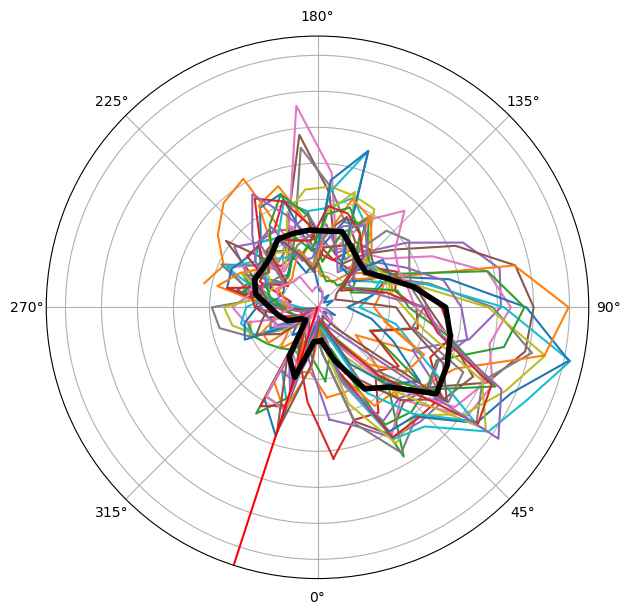

In [10]:

polar = True
fig, ax = plt.subplots(figsize=(7,8))
if polar:
    ax.remove()
    ax = fig.add_subplot(111, projection='polar')
ang_profs, ang_profs_valid = gather_ang_profs
phis_ang_prof = np.linspace(0,2*np.pi,len(ang_profs[0]))
phis_ang_prof = phis_ang_prof+(phis_ang_prof[1]-phis_ang_prof[0])/2
for j in range(len(ang_profs)):
    if ang_profs_valid[j]:
        ax.plot(phis_ang_prof, ang_profs[j])
ang_average = np.nanmean(ang_profs[ang_profs_valid], axis=0)
minipeak = signal.find_peaks(ang_average[-10:], distance=4, prominence=4)
if len(minipeak[0])>0:
    minipeak = minipeak[0][np.argmax(minipeak[1]['prominences'])]
    phi_peak = phis_ang_prof[minipeak+len(ang_average)-10]
    ax.axvline(phi_peak, c='red')
#+len(ang_average)-10
ax.plot(phis_ang_prof, ang_average, 'k', lw=4)
if not polar:
    ax.set_xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi], labels=['0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
    ax.set_yticklabels([])
    if i_plot%6==0:
        ax.set_ylabel('Intensity')
else:
    ax.set_theta_zero_location("S")
    ax.set_yticklabels([])
    

In [14]:
average_ang_prof = np.load(os.path.join(DATA_REPO, 'STED_Data', 'Average_Angular_Profile.npy'))

In [15]:
def signal_of_one_mt(phi_mt, params, phis):
    sigma, amp, offset = params
    angle_diff = jnp.abs(phis-phi_mt)
    angle_diff = jnp.minimum(angle_diff, 2*np.pi-angle_diff)
    signal = jnp.exp(-angle_diff**2/(2*sigma**2))/jnp.sqrt(2*np.pi*sigma**2)*(phis[1]-phis[0])*amp+offset
    return signal

signal_of_all_mt = jax.jit(jax.vmap(signal_of_one_mt, in_axes=(0 ,None, None)))

@jax.jit
def lossfunc_mt(phi_mts, params, phis, ang_profs_sumnormed):
    mt_signal = signal_of_all_mt(phi_mts, params, phis).sum(axis=0)/len(phi_mts)
    mt_diffs = jnp.abs((phi_mts[:,None]-phi_mts[None,:])[~np.eye(len(phi_mts), dtype=bool)])
    mt_diffs = jnp.minimum(mt_diffs, 2*np.pi-mt_diffs)
    repulsion = jnp.exp(-mt_diffs**2/(2*(0.05)**2)).sum()
    return jnp.sum((mt_signal-ang_profs_sumnormed)**2/ang_profs_sumnormed**2)+repulsion
lossfunc_mt_v = jax.jit(lambda a,b,c,d: jax.vmap(lossfunc_mt, in_axes=(0, None, None, 0))(a,b,c,d).sum())

phis_ang_prof = np.linspace(0,2*np.pi,len(average_ang_prof))
phis_ang_prof = phis_ang_prof+(phis_ang_prof[1]-phis_ang_prof[0])/2
phis_here = phis_ang_prof

0 9.429663095598015
10000 0.09467335227076408
20000 0.07637373109744075
30000 0.0736995482121911
40000 0.07192409672207513
50000 0.07031522407495668
60000 0.06874935274510453
70000 0.06720929418677622
80000 0.06570363128849328
90000 0.06424882635782536
100000 0.06286328985521333
110000 0.061563588745608036
120000 0.060362070317775934
130000 0.05926613563695716
140000 0.058278603916174614
150000 0.05739850883189374
160000 0.05662197346591115
170000 0.055943027307238866
180000 0.05535431925285338
190000 0.05484771331081797
200000 0.054414766926833946
210000 0.054047098815041564
220000 0.053736657517769675
230000 0.053475904475666754
240000 0.05325792642709132
250000 0.05307649174961471
260000 0.05292606424631652
270000 0.052801786211426324
280000 0.05269944068475604
290000 0.05261540085260275
300000 0.05254657273032214
310000 0.05249033565917121
320000 0.052444483806861716
330000 0.052407170781265146
340000 0.052376858630886446
350000 0.052352271882981416
360000 0.052332356824735624
3700

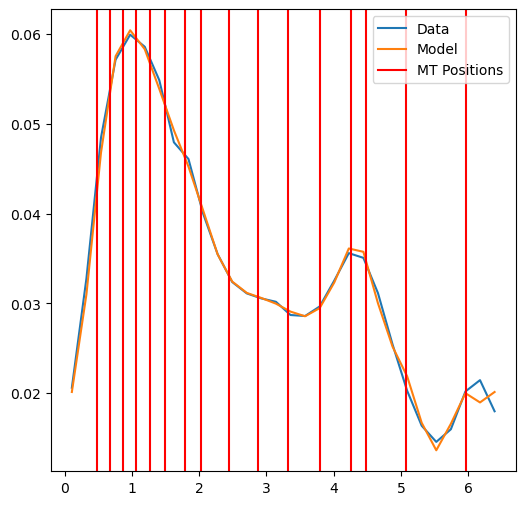

In [16]:
gradfunc = jax.jit(jax.grad(lossfunc_mt, argnums=(0,1)))

testdata = average_ang_prof
phis_mts = np.linspace(0, 2*np.pi-0.1, 16)
sigma_i, amp, offset = 0.2, 1., 0.
params = np.array([sigma_i, amp, offset])

lr_g, lr_s = 1e-4,5e-6
for i in range(1000000):
    grad = gradfunc(phis_mts, params, phis_here, testdata)
    phis_mts = phis_mts - lr_g*grad[0]
    phis_mts = phis_mts%(2*np.pi)
    params = params - lr_s*grad[1]
    if i%10000==0:
        print(i, lossfunc_mt(phis_mts, params, phis_here, testdata))

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(phis_here, testdata, label='Data')
ax.plot(phis_here, signal_of_all_mt(phis_mts, params, phis_here).sum(axis=0)/len(phis_mts), label='Model')
for p in phis_mts:
    ax.axvline(p, c='red', label='MT Positions' if p==phis_mts[0] else None)
plt.legend()
print(params)